In [29]:
# --- Imports ---
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [30]:
# --- Settings ---
LOG_DIR = "../logs/subway"  # folder where monitor CSVs are saved
MODEL_DIR = "./models/subway"
sns.set(style="whitegrid")

In [31]:
# --- Load Eval Metric CSVs ---
def load_eval_csvs(eval_dir=LOG_DIR):
    csv_files = glob(os.path.join(eval_dir, "*_metrics.csv"))
    dfs = []
    for f in csv_files:
        name = os.path.basename(f).replace("_metrics.csv", "")
        parts = name.split("_")
        algo = parts[0] if parts[0] in ["ppo", "a2c"] else "unknown"
        persona = "survivor" if "survivor" in parts else "explorer"
        df = pd.read_csv(f)
        df["algo"] = algo
        df["persona"] = persona
        df["file"] = name
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

eval_df = load_eval_csvs()
print(f"Loaded {len(eval_df)} evaluation episodes across {eval_df['file'].nunique()} runs.")
eval_df.head()

Loaded 40 evaluation episodes across 4 runs.


,episode,reward,score,steps,lane_changes,terminated,truncated,unique_lanes,algo,persona,file
0,1,31.5,3,25,25,1,0,2,a2c,explorer,a2c_explorer
1,2,27.6,0,22,22,1,0,2,a2c,explorer,a2c_explorer
2,3,31.5,9,25,25,1,0,2,a2c,explorer,a2c_explorer
3,4,40.6,12,32,32,1,0,2,a2c,explorer,a2c_explorer
4,5,28.9,5,23,23,1,0,2,a2c,explorer,a2c_explorer


In [32]:
# --- Load Monitor CSVs ---
def load_monitor_csvs(log_dir=LOG_DIR):
    # Find CSVs directly under logs folder
    csv_files = glob(os.path.join(log_dir, "*_monitor.csv"))
    if not csv_files:
        raise ValueError(f"No monitor CSV files found in {log_dir} matching *_monitor.csv")

    dfs = []
    for f in csv_files:
        # Extract algo and persona from filename
        fname = os.path.basename(f).replace("_monitor.csv", "")
        parts = fname.split("_")
        algo = parts[0] if parts[0] in ["ppo", "a2c"] else "unknown"
        persona = parts[1] if len(parts) > 1 else "unknown"

        # Read CSV, SB3 monitor CSV already has header r,l,t
        df = pd.read_csv(f, comment="#")  # skip SB3 metadata lines starting with #
        df.rename(columns={"r":"reward","l":"length","t":"time"}, inplace=True)

        df["algo"] = algo
        df["persona"] = persona
        df["file"] = fname
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

df = load_monitor_csvs()
print(f"Loaded {len(df)} episodes across {df['file'].nunique()} runs.")
df.head()

Loaded 31161 episodes across 4 runs.


,reward,length,time,algo,persona,file
0,29.0,22,0.380639,a2c,explorer,a2c_explorer
1,26.5,23,0.395874,a2c,explorer,a2c_explorer
2,27.5,23,0.432209,a2c,explorer,a2c_explorer
3,25.5,21,0.450498,a2c,explorer,a2c_explorer
4,34.5,29,0.476817,a2c,explorer,a2c_explorer


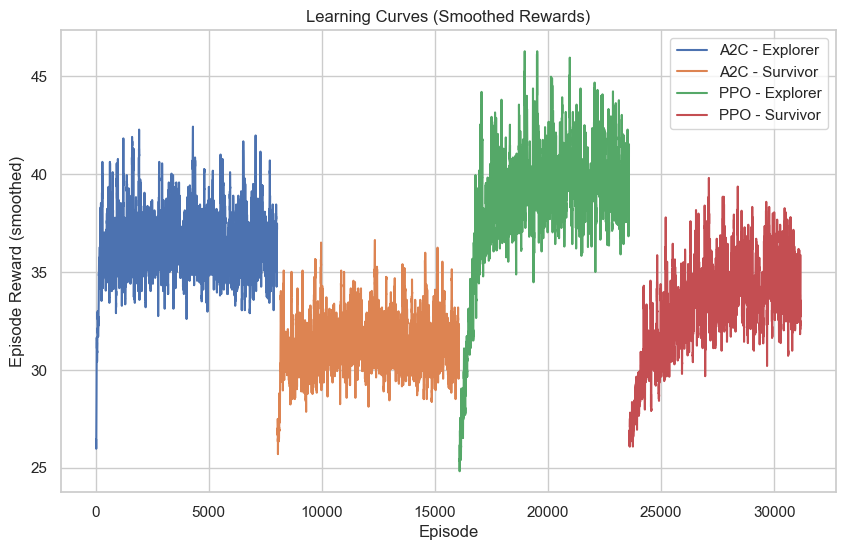

In [33]:
plt.figure(figsize=(10,6))
for (algo, persona), group in df.groupby(["algo", "persona"]):
    # Use rolling mean for smoothing
    smoothed = group["reward"].rolling(20).mean()
    plt.plot(smoothed, label=f"{algo.upper()} - {persona.title()}")

plt.title("Learning Curves (Smoothed Rewards)")
plt.xlabel("Episode")
plt.ylabel("Episode Reward (smoothed)")
plt.legend()
plt.show()

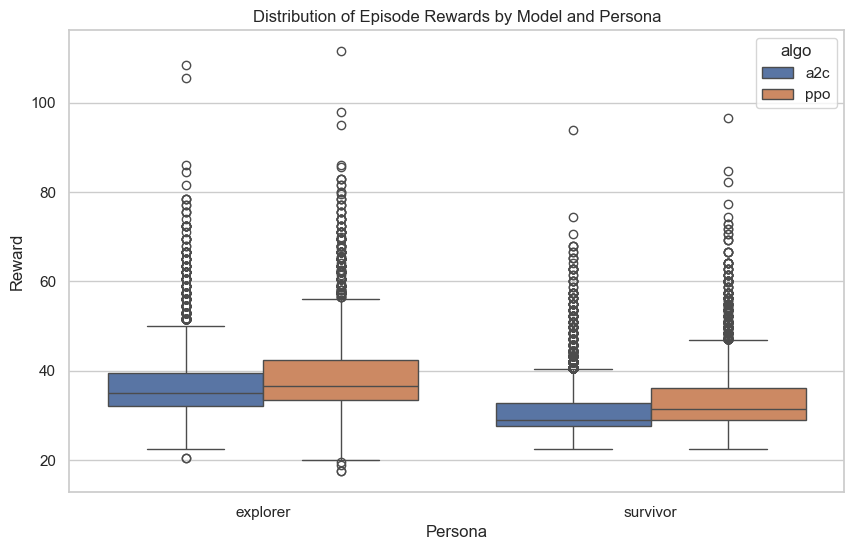

In [34]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="persona", y="reward", hue="algo")
plt.title("Distribution of Episode Rewards by Model and Persona")
plt.xlabel("Persona")
plt.ylabel("Reward")
plt.show()

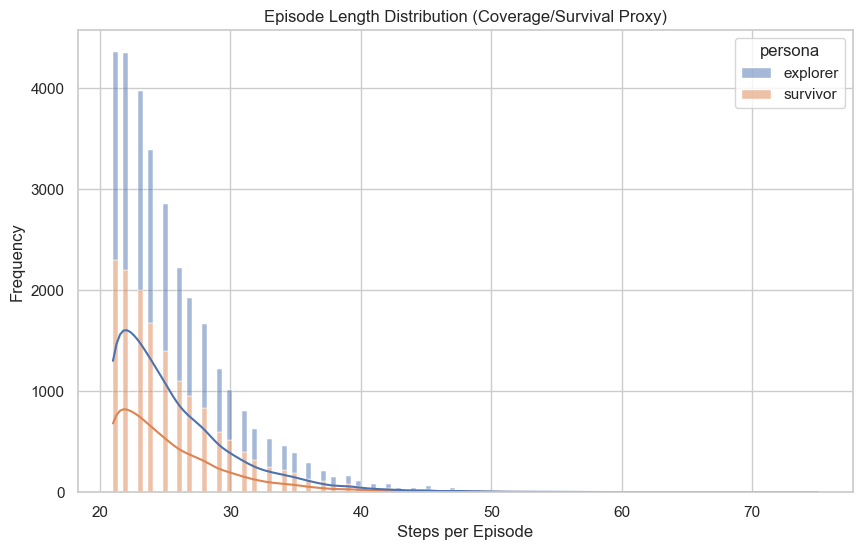

In [35]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="length", hue="persona", multiple="stack", kde=True)
plt.title("Episode Length Distribution (Coverage/Survival Proxy)")
plt.xlabel("Steps per Episode")
plt.ylabel("Frequency")
plt.show()

In [36]:
summary = df.groupby(["algo", "persona"]).agg({
    "reward": ["mean", "std"],
    "length": ["mean", "std"]
}).round(2)

summary.columns = ["_".join(col) for col in summary.columns]
summary.reset_index(inplace=True)
summary

,algo,persona,reward_mean,reward_std,length_mean,length_std
0,a2c,explorer,36.35,6.71,24.93,4.45
1,a2c,survivor,31.28,5.70,24.87,4.37
2,ppo,explorer,38.63,7.94,26.71,5.07
3,ppo,survivor,33.22,6.64,26.46,5.04


<Figure size 800x600 with 0 Axes>

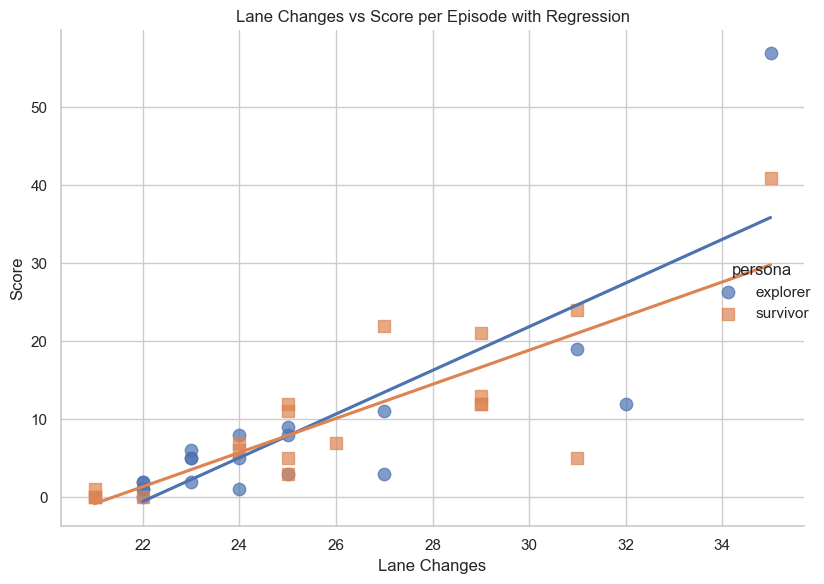

In [37]:
plt.figure(figsize=(8,6))

# Scatter with regression lines per persona
sns.lmplot(
    data=eval_df,
    x="lane_changes",
    y="score",
    hue="persona",
    markers=["o", "s"],  # marker per persona
    height=6,
    aspect=1.2,
    ci=None,             # no confidence interval band
    scatter_kws={"s":80, "alpha":0.7}
)

plt.title("Lane Changes vs Score per Episode with Regression")
plt.xlabel("Lane Changes")
plt.ylabel("Score")
plt.tight_layout()
plt.show()